<h1><center> SAM pipeline inference on part 5 dataset

In [51]:
# dependencies 
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import rasterio
import os
import sys
import random
from rasterio.plot import show

In [18]:
os.chdir("/Users/mayajanvier/Desktop/MVA/Remote sensing/Projet 6/projet_remote")

# SAM

In [19]:
# get sam
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

model_type = "vit_h"
checkpoint_path = 'checkpoint/sam_vit_h_4b8939.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device=device)
predictor = SamPredictor(sam)

In [20]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [21]:
def show_prompts(img,prompts,labels):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_points(prompts, labels, plt.gca())
    plt.axis('on')
    plt.show() 

def sam_predict(input_points,input_labels):
    masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,)
    return masks, scores, logits
    
def show_predictions(masks, scores,input_points, input_labels,img):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        show_mask(mask, plt.gca())
        show_points(input_points, input_labels, plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show() 


# Processing functions for SAR data

In [30]:
# file processing
def read_rasterio(fp):
    img = rasterio.open(fp)
    img = img.read()
    img = np.moveaxis(img, 0, -1)
    return img

def standardize_minmax(array):
    stand = (array - array.min()) / (array.max() - array.min())
    return (stand * 255).astype(np.uint8)

def sar2rgb(path_sar_image):
    sar = read_rasterio(path_sar_image)
    vv = standardize_minmax(sar[:,:,0])
    vh = standardize_minmax(sar[:,:,1])
    diff = vv - vh
    img_3d = np.stack([vv,vh,diff], axis=-1) 
    return img_3d


In [31]:
# Morphological processing
from skimage.filters import try_all_threshold, threshold_li, frangi, median, threshold_multiotsu

def morphological_processing(vh_band):
    mask = vh_band < threshold_li(vh_band)
    return mask

In [53]:
# Get prompts methods 
def get_prompt_points(mask):
    step = len(mask) // 10
    prompt_points = []
    labels = []
    
    for i in range(0, mask.shape[0], step):
        for j in range(0, mask.shape[1], step):
            submask = mask[i:i+step, j:j+step]
            land_count = np.count_nonzero(submask == False)
            water_count = np.count_nonzero(submask == True)
            #print(land_count, water_count)
            
            if land_count > water_count:
                dom_label = 0  # Land is the dominant class
            else:
                dom_label = 1  # Water is the dominant class
            #print(dom_label)
                
            # Get the indices of all pixels belonging to the dominant class
            dominant_class_pixels_indices = np.where(submask == dom_label)[0]
            # Randomly select one pixel index from the dominant class
            random_pixel_index = np.random.choice(dominant_class_pixels_indices)
            # Convert pixel index to coordinates
            random_pixel_coordinates = np.unravel_index(random_pixel_index, submask.shape)
            # Add the random pixel coordinates to the prompt points list
            prompt_points.append([j + random_pixel_coordinates[1], i + random_pixel_coordinates[0]])
            labels.append(dom_label)

    
    return np.array(prompt_points),np.array(labels)

def get_near_center_points(mask):
    step = len(mask) // 10 
    near_center_points = []
    labels = []
    
    for i in range(0, mask.shape[0], step):
        for j in range(0, mask.shape[1], step):
            submask = mask[i:i+step, j:j+step]
            land_count = np.count_nonzero(submask == False)
            water_count = np.count_nonzero(submask == True)
            
            if land_count > water_count:
                dom_label = 0  # Land is the dominant class
            else:
                dom_label = 1  # Water is the dominant class
                
            # Calculate the center coordinates of the submask
            #center_row = i + step // 2
            #center_col = j + step // 2
            
            # Search for the nearest dominant class pixel to the center coordinates
            dist_to_center = np.sum(np.abs(np.argwhere(submask == dom_label) - np.array([step // 2, step // 2])), axis=1)
            nearest_index = np.argmin(dist_to_center)
            nearest_coords = np.argwhere(submask == dom_label)[nearest_index]
            
            # Add the nearest coordinates to the near-center points list
            near_center_points.append([j + nearest_coords[1], i + nearest_coords[0]])  # Note the order: [col, row]
            labels.append(dom_label)
    
    return np.array(near_center_points), np.array(labels)

def prompt_points(image, window_size=100):
        
    # Obtenir les dimensions de l'image
    height, width = image.shape
    
    # Préparer une liste pour stocker les points et leurs labels
    points = []
    labels = []
    
    # Découper l'image en grilles
    for i in range(0, height, window_size):
        for j in range(0, width, window_size):
            window = image[i:i+window_size, j:j+window_size]
            
            unique, counts = np.unique(window, return_counts=True)
            window_class_counts = dict(zip(unique, counts))
            
            major_class = max(window_class_counts, key=window_class_counts.get)
            
            indices = np.argwhere(window == major_class)
            
            # Choisir un point aléatoire parmi ceux de la classe majoritaire
            if indices.size > 0:
                random_index = random.choice(indices)
                point = [j + random_index[1], i + random_index[0]]  # (x, y)
                points.append(point)
                labels.append(major_class)
    
    return np.array(points), np.array(labels) 


# Pipeline

In [58]:
img_id = '75'

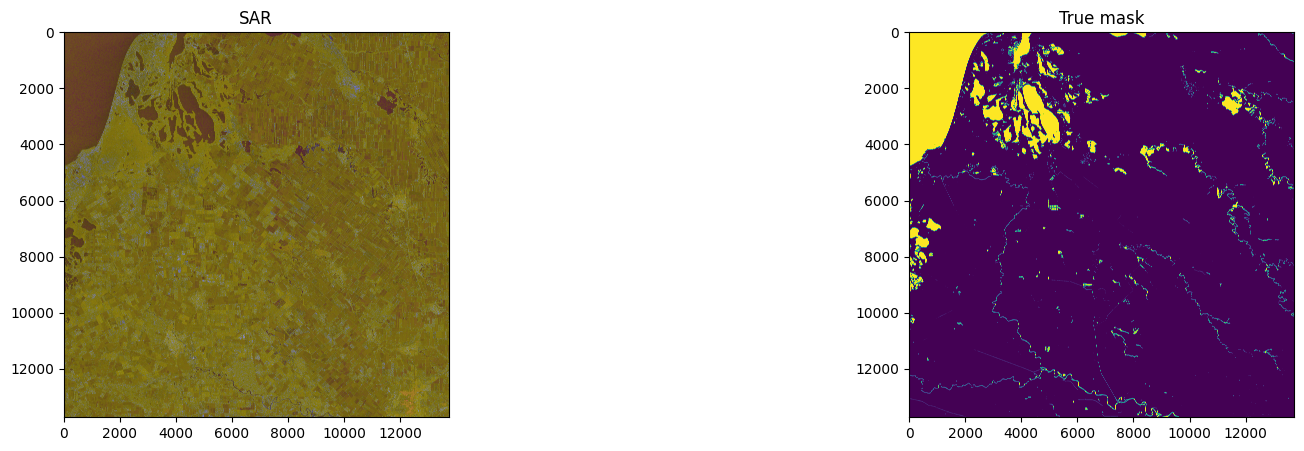

In [60]:
img_path = f'part5/{img_id}/sentinel12_s1_{img_id}_img.tif'
mask_path = f'part5/{img_id}/sentinel12_s1_{img_id}_msk.tif'

# plots 
true_mask = read_rasterio(mask_path)
img = sar2rgb(img_path)

# full size
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].imshow(img)
ax[0].set_title('SAR')
ax[1].imshow(true_mask)
ax[1].set_title('True mask')
plt.show()


Text(0.5, 1.0, 'Crop')

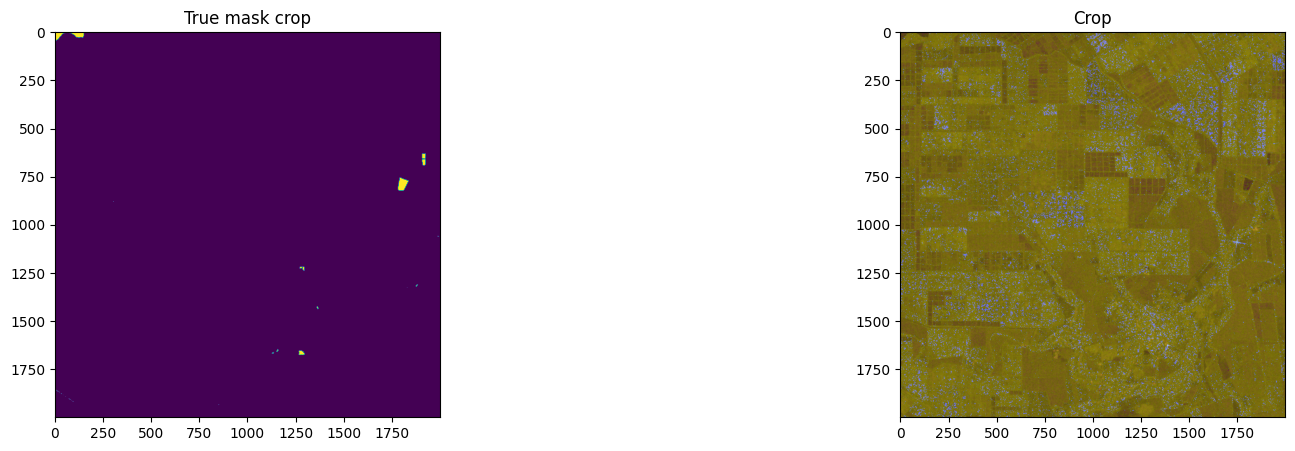

In [80]:
crop_indices = [7000,9000,1000,3000]
crop = img[crop_indices[0]:crop_indices[1],crop_indices[2]:crop_indices[3],:]
crop_resize = cv2.resize(crop,(1000,1000))

# crop 
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].imshow(true_mask[crop_indices[0]:crop_indices[1],crop_indices[2]:crop_indices[3],:])
ax[0].set_title('True mask crop')
ax[1].imshow(crop)
ax[1].set_title('Crop')

In [81]:
# set sam 
predictor.set_image(crop)

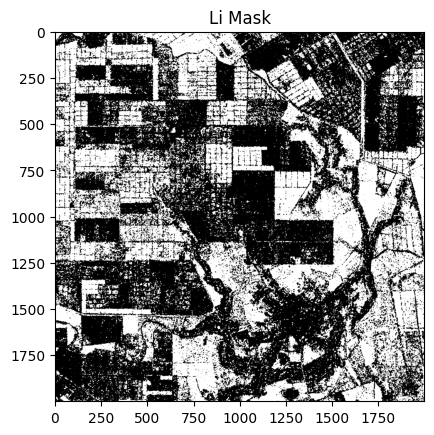

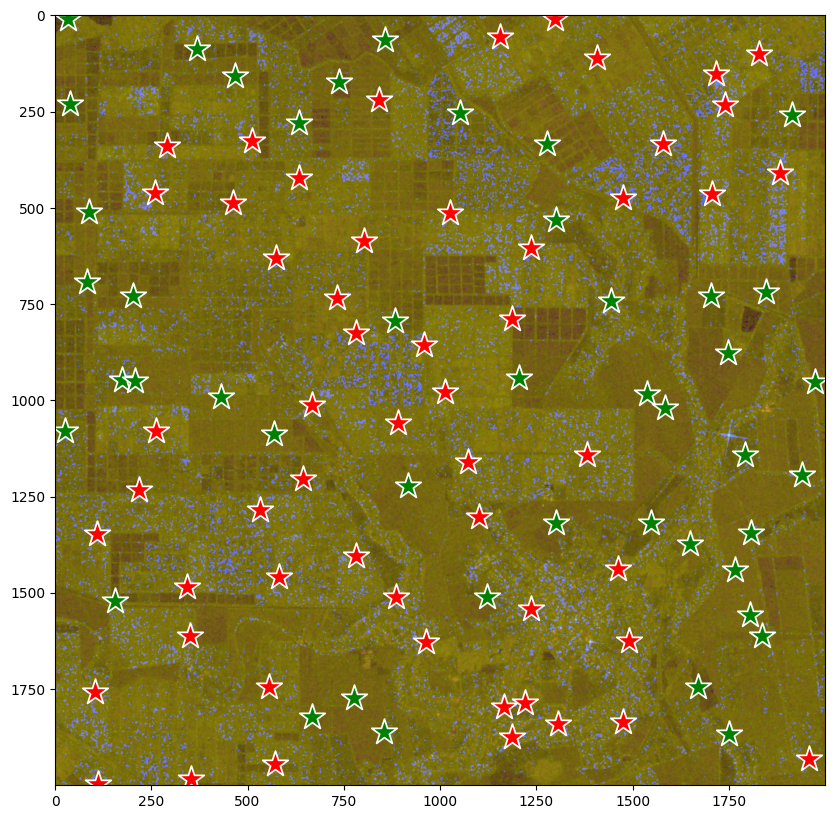

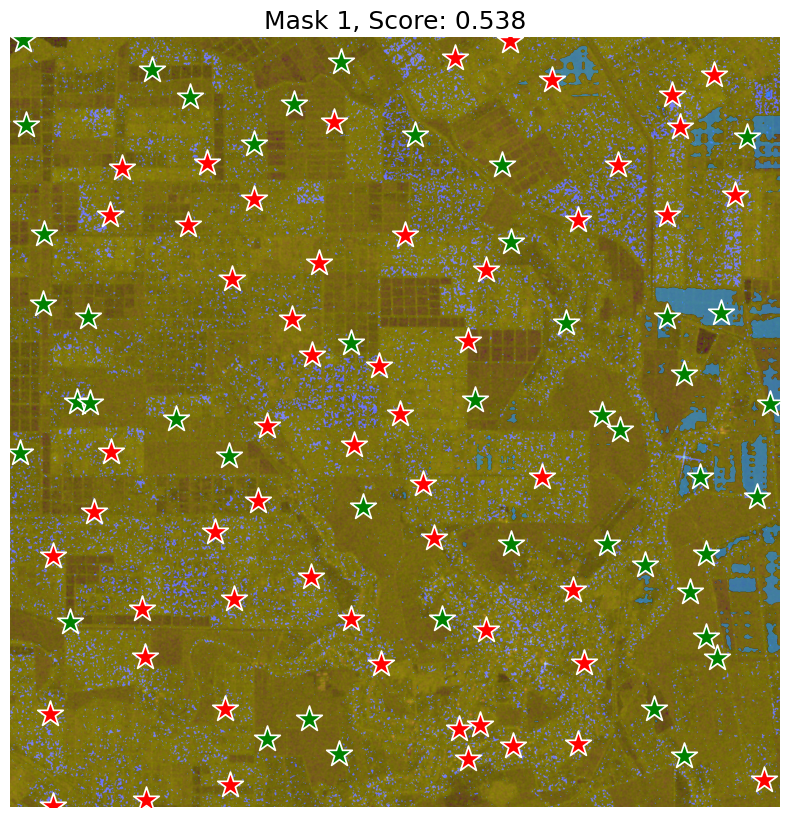

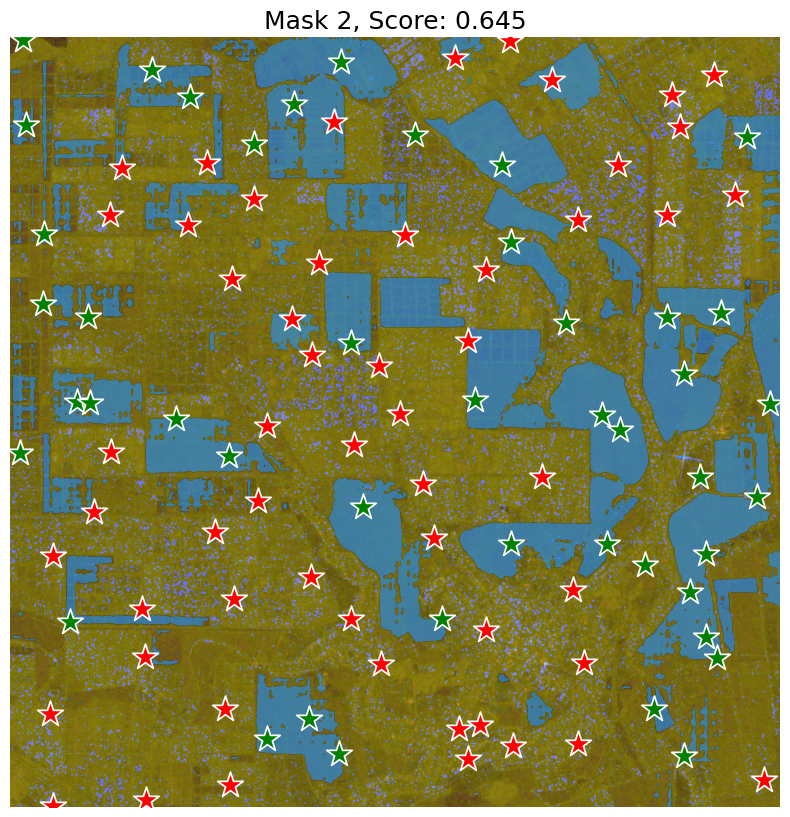

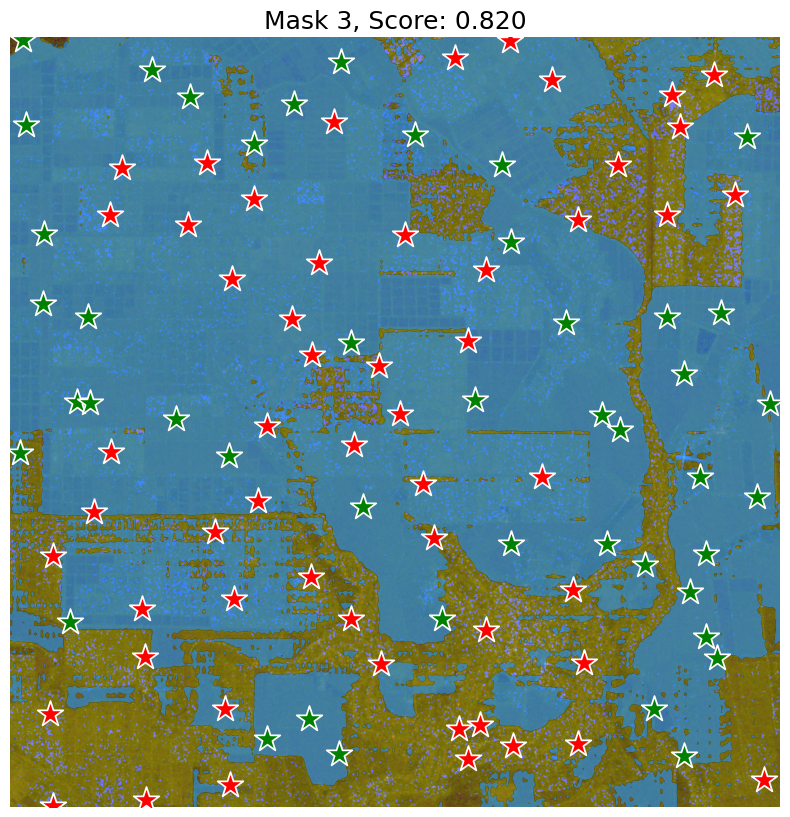

In [82]:
# morphological mask
vh_band = crop[:,:,1]
mask = morphological_processing(vh_band)
plt.imshow(mask,cmap='gray')
plt.title('Li Mask')
plt.show()

# prompts and labels for SAM 
prompts, labels = prompt_points(mask, window_size=mask.shape[0]//10)
show_prompts(crop,prompts,labels)

# predict
masks, scores, logits = sam_predict(prompts,labels)
show_predictions(masks, scores, prompts, labels, crop)